## Reflection and transmission at boudaries and interfaces on string

We consider a semi infinite string fixed at x = 0. The mass density for $0<x<h_1$ is $\rho_1$ and for $h_1<x<\infty$ is $\rho_2$. Considering wave speed of $c_1$ and $c_2$ for the frist and second part of the string, the reflection and transmission ratios at the interface can be computed as follows:

$R = \frac{c_2-c_1}{c_2+c_1}$

$T = \frac{2c_2}{c_2+c_1}$

Reflection ratio is:  -0.3333333333333333
Transmission ratio is:  0.6666666666666666


<IPython.core.display.Javascript object>


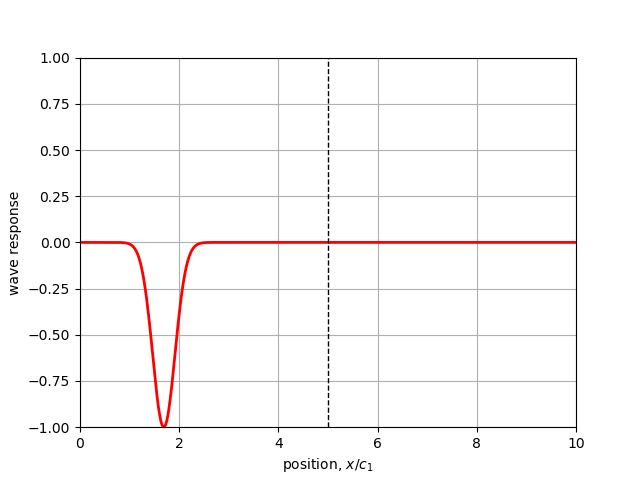

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from scipy import integrate
from numpy.linalg import inv
%matplotlib notebook

H = 1000
x  = np.linspace(0,H,1000)
Le = x[1]-x[0]
        
nnode = x.shape[0]
nelem = nnode-1

T   = 20e6
rho = 2000 

c1 = np.sqrt(T/rho)
c2 = np.sqrt(T/rho/4)

R = (c2-c1)/(c2+c1) 
print('Reflection ratio is: ',R)
Tr= 2*c2/(c2+c1)
print('Transmission ratio is: ',Tr)


dt = 0.01
f0 = 1
n  = 2000
t0 = 1.5

t = np.linspace(0,1,n)*dt*(n-1)

def ricker(f0,t0,t):
    tau = t-t0
    aw  = (1-2*tau*tau*f0**2*np.pi**2)*np.exp(-tau**2*np.pi**2*f0**2);
    vw  = integrate.cumtrapz(aw,t,initial=0)
    uw  = integrate.cumtrapz(vw,t,initial=0)
    return aw,vw,uw

aw,vw,uw = ricker(f0,t0,t)

amp = np.amax(np.abs(uw))
uw = uw/amp
vw = vw/amp
aw = aw/amp

K = np.zeros((nnode,nnode))
C = np.zeros((nnode,nnode))
M = np.zeros((nnode,nnode))

for j in range(nelem):
    node1 = j
    node2 = j+1
    if j>nelem/2:
        rho1 = 4*rho
    else:
        rho1 = rho
    K[node1,node1] +=  T/Le;
    K[node1,node2] += -T/Le;
    K[node2,node1] += -T/Le;
    K[node2,node2] +=  T/Le;
    M[node1,node1] +=  rho1*Le/3;
    M[node1,node2] +=  rho1*Le/6;
    M[node2,node1] +=  rho1*Le/6;
    M[node2,node2] +=  rho1*Le/3;

C[nnode-1,nnode-1] = rho*4*np.sqrt(T/rho/4);

Kff = K[1:nnode+1,1:nnode+1]
Mff = M[1:nnode+1,1:nnode+1]
Cff = C[1:nnode+1,1:nnode+1]
Kfo = K[1:nnode+1,0]
Mfo = M[1:nnode+1,0]
Cfo = C[1:nnode+1,0]

Kfo = np.reshape(Kfo,(nnode-1,1))
Cfo = np.reshape(Cfo,(nnode-1,1))
Mfo = np.reshape(Mfo,(nnode-1,1))

gamma = 0.50
beta  = 0.25

U = np.zeros((nnode,n))
V = np.zeros((nnode,n)) 
A = np.zeros((nnode,n))
U[0,:] = uw
V[0,:] = vw
A[0,:] = aw

F =-Mfo*aw[0]-Cfo*vw[0]-Kfo*uw[0]
Mstar = Mff + gamma*dt*Cff + beta*dt**2*Kff
MstatInv = inv(Mstar)

for i in range(1,n):
    F     = -Mfo*aw[i]-Cfo*vw[i]-Kfo*uw[i]
    Uhat  = U[1:,i-1] + dt*V[1:,i-1] + (1-2*beta)/2*dt**2*A[1:,i-1]
    Vhat  = V[1:,i-1] + (1-gamma)*dt*A[1:,i-1]
    Uhat  = np.reshape(Uhat,(nnode-1,1))
    Vhat  = np.reshape(Vhat,(nnode-1,1))
    Fstar = F - np.dot(Cff,Vhat) - np.dot(Kff,Uhat)
    a = np.dot(MstatInv,Fstar)
    A[1:,i] = np.reshape(a,(nnode-1,))
    U[1:,i] = np.reshape(Uhat + beta*dt**2*a,(nnode-1,))
    V[1:,i] = np.reshape(Vhat + gamma*dt*a,(nnode-1,))
 
fig=plt.figure()
ax = plt.axes(xlim=(0,H/c1), ylim=(-1, 1),xlabel='position, $x/c_1$',ylabel = 'wave response')
ax.grid()
line1, = ax.plot([], [], lw=2,color='r')
line2, = ax.plot([], [], lw=1,color='k',linestyle='--')

def init():
    line1.set_data([],[])
    line2.set_data([],[])
    return line1,line2

def animate(i):
    line1.set_data(x/c1, U[:,i])
    line2.set_data([H/2/c1,H/2/c1],[-1,1])
    return line1,line2

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=2000, interval=10, blit=True)